# 은행 이탈 데이터 셋을 이용한 이진 분류
[Binary Classification with a Bank Churn Dataset](https://www.kaggle.com/competitions/playground-series-s4e1/overview)

# 1. 문제 정의(개요)
은행 고객 이탈 예측 관련 데이터셋을 사용해 이진 분류 모델을 구축하는 것을 목적으로 합니다. 이 데이터셋에는 고객ID, 이름, 신용점수, 국가, 성별, 나이, 보유기간, 잔액, 제품 수, 신용카드 상태, 활성 멤버쉽, 예상 급여 및 이 데이터 셋의 메인 학습 라벨인 고객 이탈 여부 등 다양한 특성들이 포함되어 있습니다. 이 프로젝트는 데이터 탐색, 전처리, 모델 선택 및 훈련, 모델 평가, 결과 시각화, 배포의 단계로 진행됩니다. 주어진 데이터를 가지고 모델을 학습시켜 고객의 이탈 예측 및 방지를 목표로 두고 있습니다.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import missingno as msno
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from visualization import *

%matplotlib inline

rc('font', family='Malgun Gothic')
sns.set_style('whitegrid')

In [3]:
# orginal_data를 불러서 합치는게 좋을지?
df = pd.read_csv('../data/train.csv/train.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


# 2. 데이터 탐색 및 전처리
- train 데이터 컬럼
    - id: ID
    - CustomerId: 고객ID
    - Surname: 성(이름)
    - CreditScore: 신용점수
    - Geography: 지역(국가)
    - Gender: 성별
    - Age: 나이
    - Tenure: 가입기간
    - Balance: 잔액
    - NumOfProducts: 고객 보유 상품 수
    - HasCrCard: 신용카드 유무 (1: Yes, 0: No)
    - IsActiveMember: 활성 멤버쉽 (1: Yes, 0: No)
    - EstimatedSalary: 예상 급여
    - Exited: 이탈 유무(1: Yes, 0: No) => 타겟 컬럼
---
- HasCrCard, IsActiveMember는 숫자로 되어 있지만 실질적으로는 범주형 데이터로 고려해야 함
- id, CustomerID, Surname은 데이터를 특정하고 분석에 의미를 갖지 않기 때문에 분석에서 제외

> 범주형 데이터
- Geography, Gender, HasCrCard, IsActiveMember

> 수치형 데이터
- CreditScore, Age, Tenure, Balance, EstimatedSalary

> 타겟
- Exited

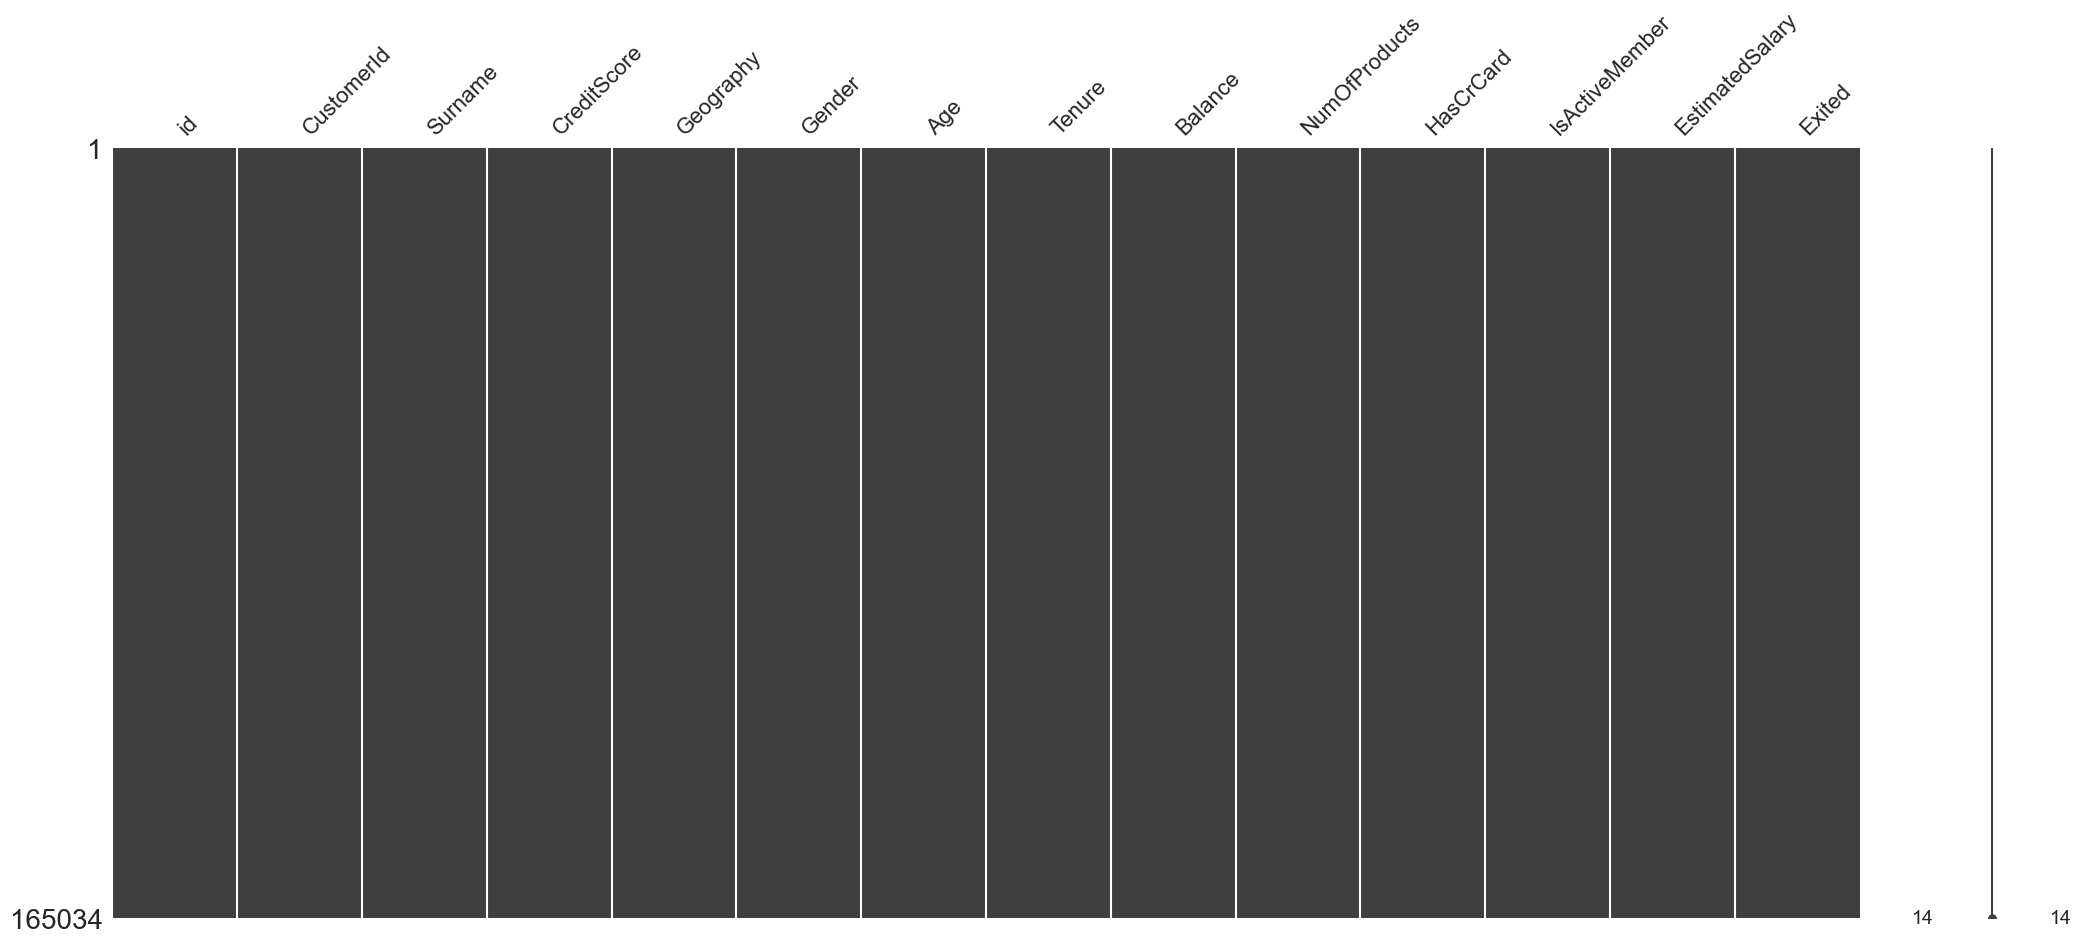

In [5]:
# 결측치 확인
msno.matrix(df)
plt.show()

In [6]:
# 중복데이터 확인
df.duplicated().sum()

0

## 타켓 컬럼 비율 확인

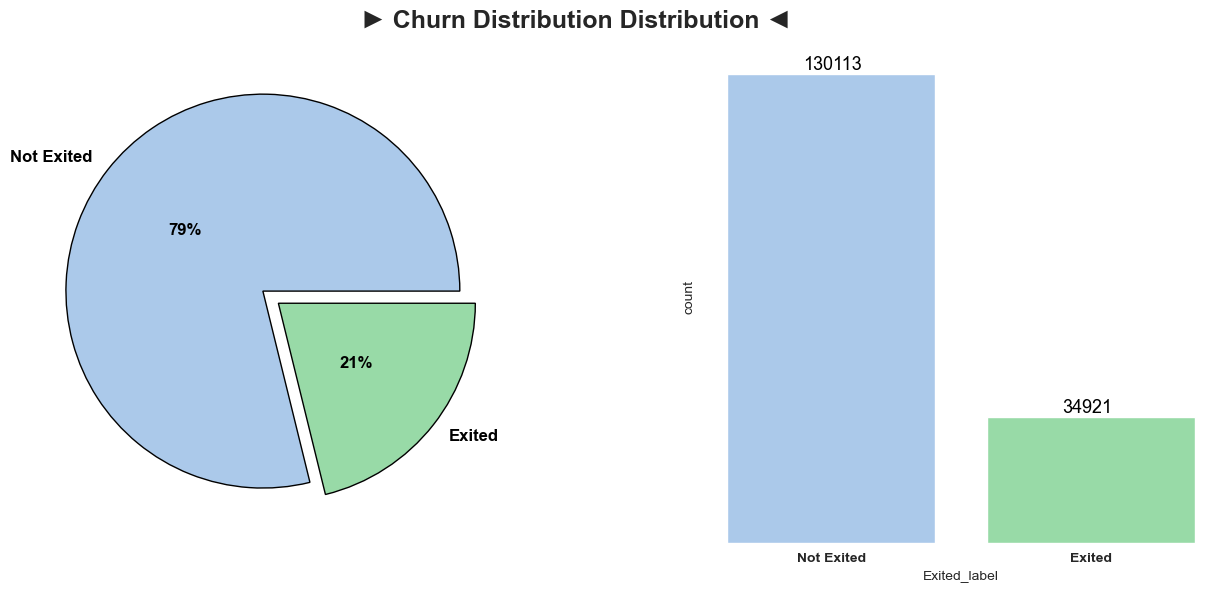

In [10]:
df['Exited_label'] = df['Exited'].map({1: 'Exited', 0: 'Not Exited'})

def plot_target(df: pd.DataFrame, col: str, title: str, pie_colors:list) -> None:
    fig, ax = plt.subplots(1,2,figsize=(15, 6), width_ratios=[2,1])

    textprops={'fontsize': 12, 'weight': 'bold',"color": "black"}
    ax[0].pie(df[col].value_counts().to_list(),
            colors=pie_colors,
            labels=df[col].value_counts().index.to_list(),
            autopct='%1.f%%', 
            explode=([.05]*df[col].nunique()),
            pctdistance=0.5,
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops=textprops)

    sns.countplot(x = col, data=df, palette = "pastel6", order=df[col].value_counts().to_dict().keys())
    for p, count in enumerate(df[col].value_counts()):
        ax[1].text(p-0.11, count+np.sqrt(count)+1000, count, color='black', fontsize=13)
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    plt.yticks([])
    plt.box(False)
    fig.suptitle(x=0.56, t=f'► {title} Distribution ◄', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_target(df, 
            col='Exited_label', 
            title='Churn Distribution', 
            pie_colors=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])

> 타겟이 되는 Exited의 값이 8:2로 불균형함
- 향후 모델링 과정에서 문제를 해결하기 위한 오버 샘플링을 고려

# 3. 데이터 분석

In [11]:
# 범주형/수치형 컬럼 구분
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

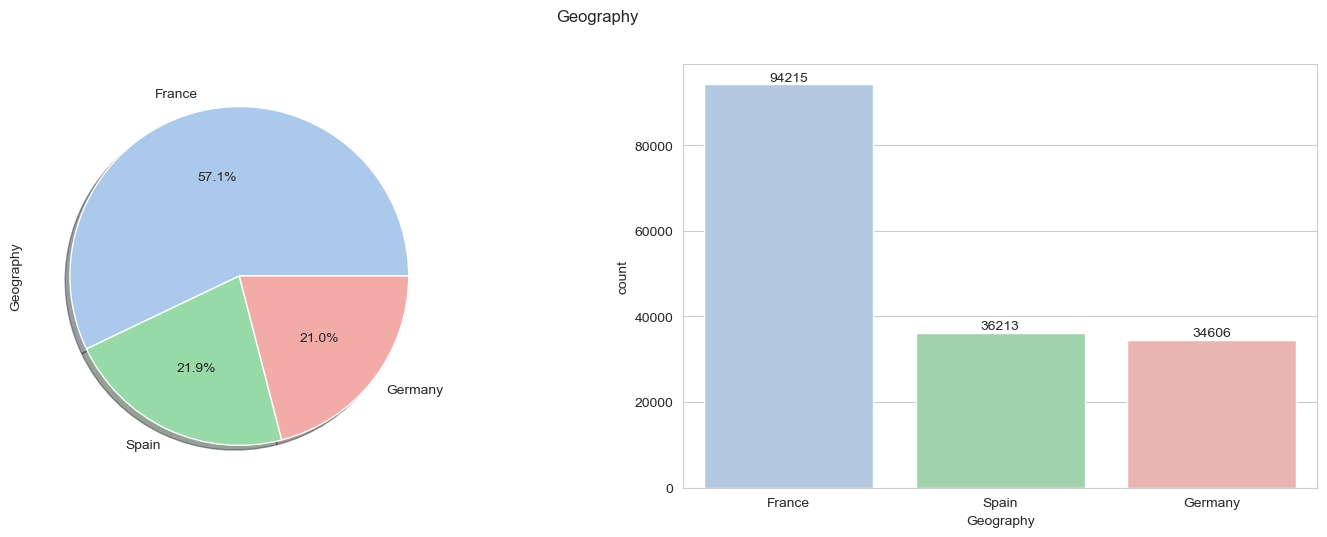

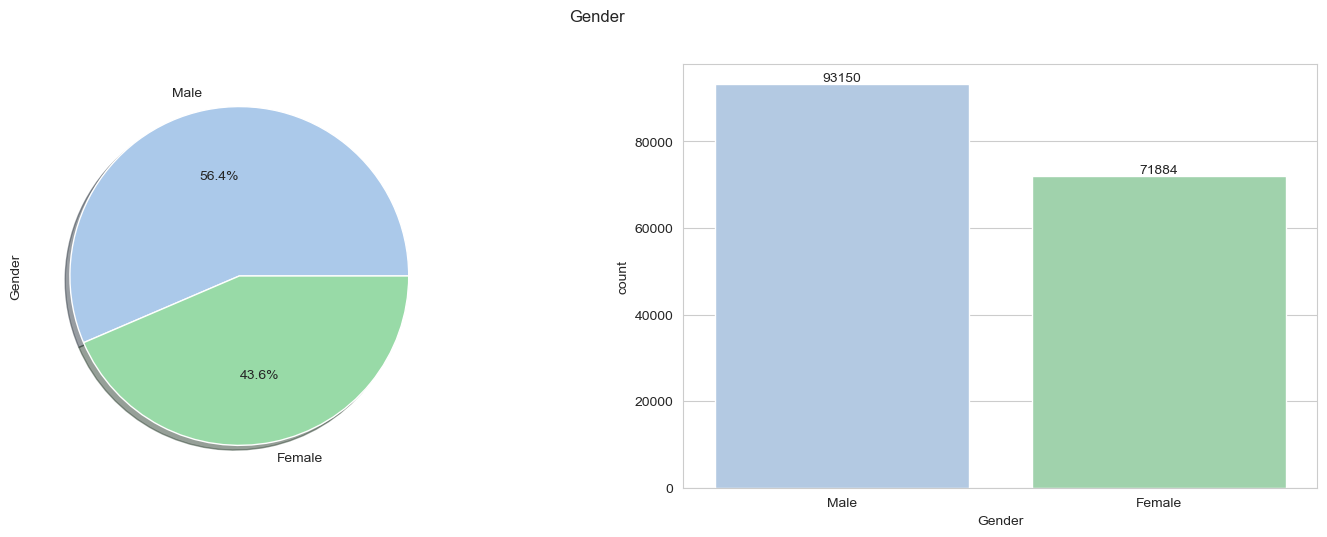

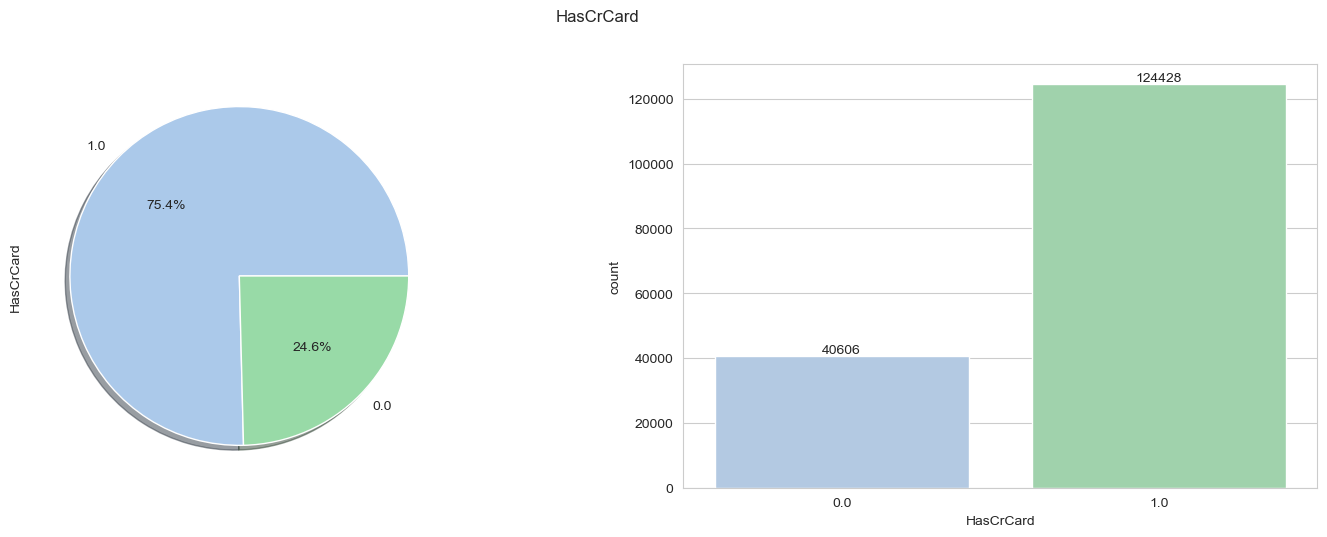

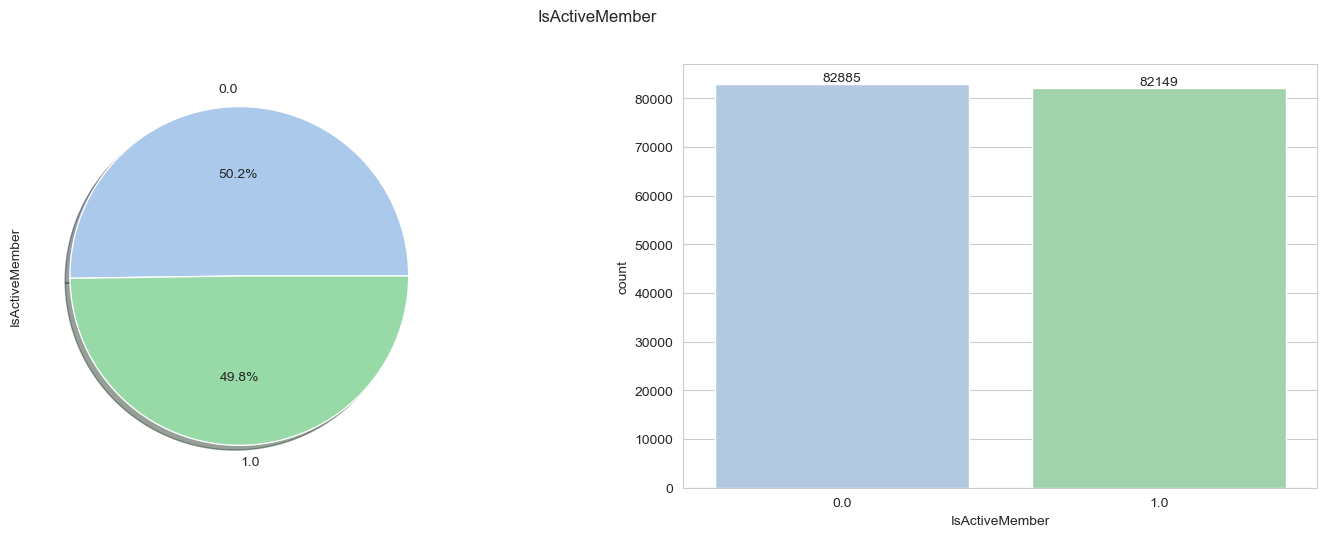

In [15]:
for column in cat_cols:
    f,ax=plt.subplots(1,2,figsize=(18,5.5))
    df[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,colors=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column,data=df,ax=ax[1], palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])
    ax[1].bar_label(ax[1].containers[0])
    plt.suptitle(f'{column}')
    plt.show()

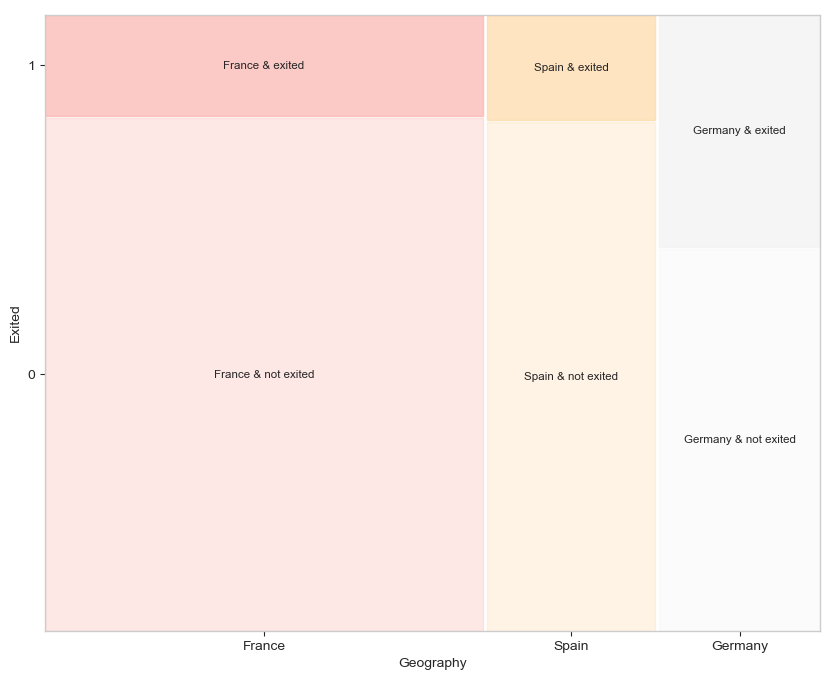

In [27]:
create_mosaic_plot(df, 'Geography', 'Exited')

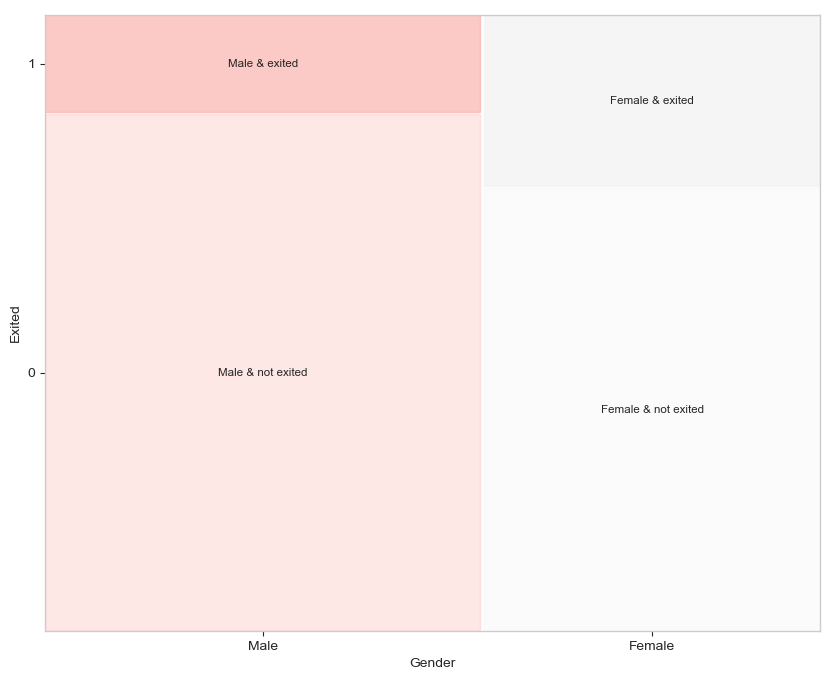

In [22]:
create_mosaic_plot(df, 'Gender', 'Exited')

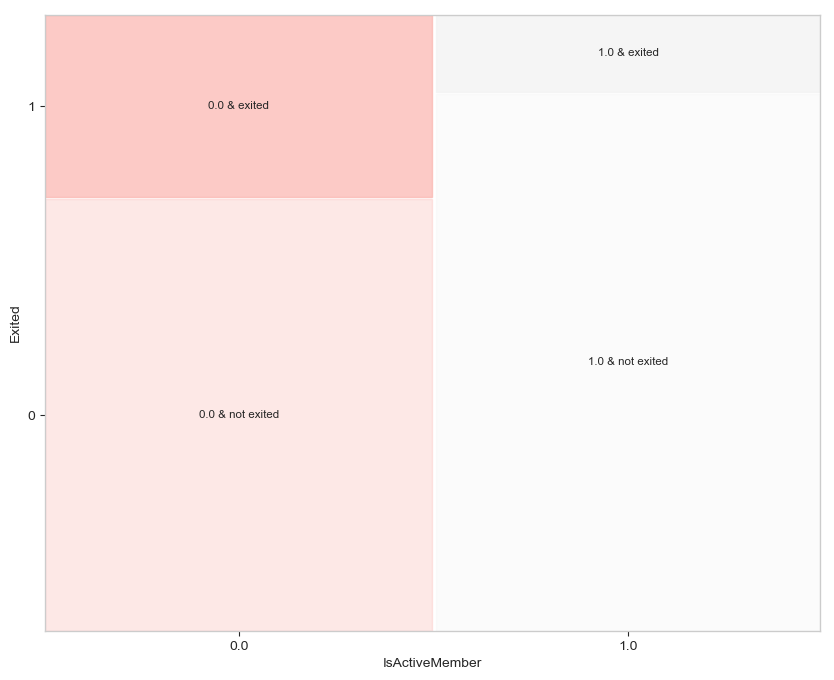

In [20]:
create_mosaic_plot(df, 'IsActiveMember', 'Exited')

### 범주형 컬럼 관찰 결과:
- 거주 국가별 가장 많은 이탈수는 가장 고객이 많은 프랑스이지만 비율로 봤을 때는 독일의 이탈률이 가장 큽니다.
- 성별 이탈 수에서는 여성의 이탈 비율이 높은 것으로 보입니다.
- 비활성 고객들의 이탈률이 높습니다.

c:\ZERO\ML_Team_Project\eda_source\visualization.py:87: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.histplot(x=x, hue=hue, data=df, kde=True, bins=bins, palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])


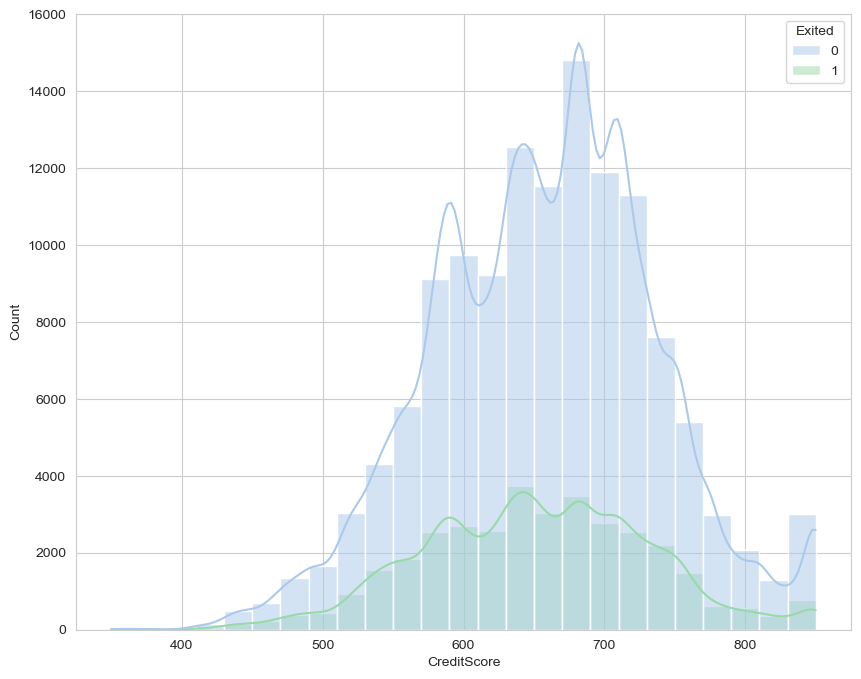

c:\ZERO\ML_Team_Project\eda_source\visualization.py:87: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.histplot(x=x, hue=hue, data=df, kde=True, bins=bins, palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])


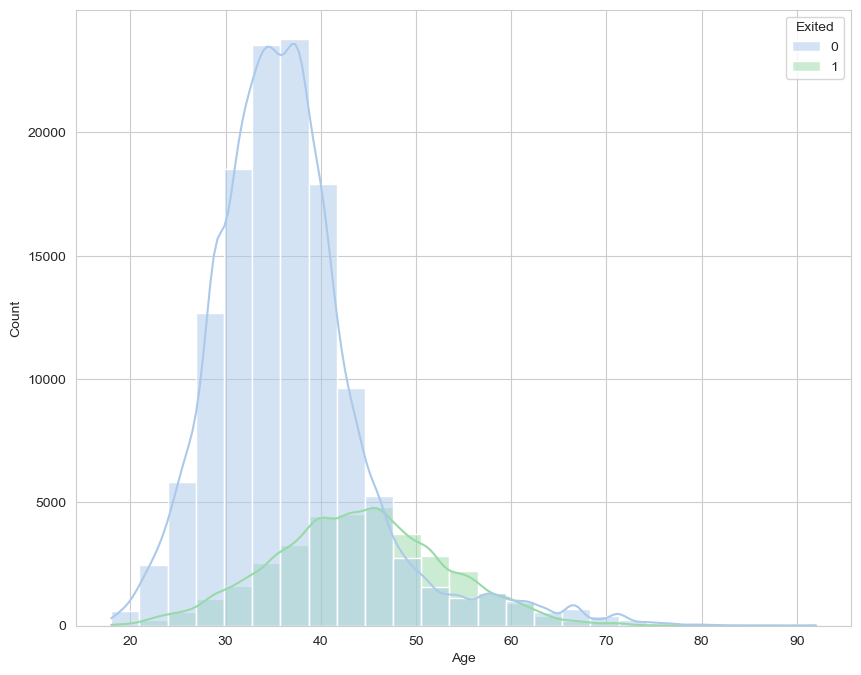

c:\ZERO\ML_Team_Project\eda_source\visualization.py:87: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.histplot(x=x, hue=hue, data=df, kde=True, bins=bins, palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])


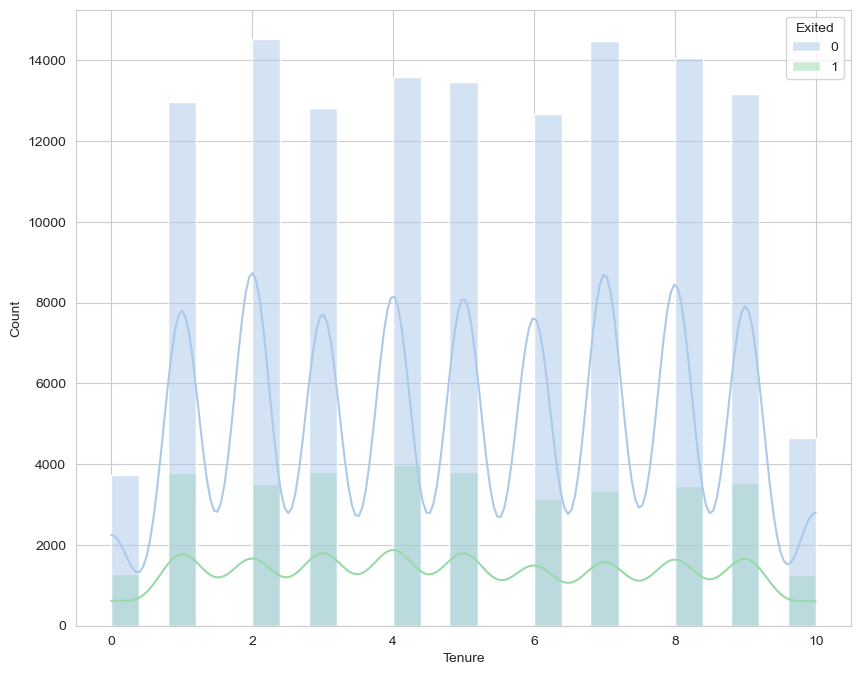

c:\ZERO\ML_Team_Project\eda_source\visualization.py:87: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.histplot(x=x, hue=hue, data=df, kde=True, bins=bins, palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])


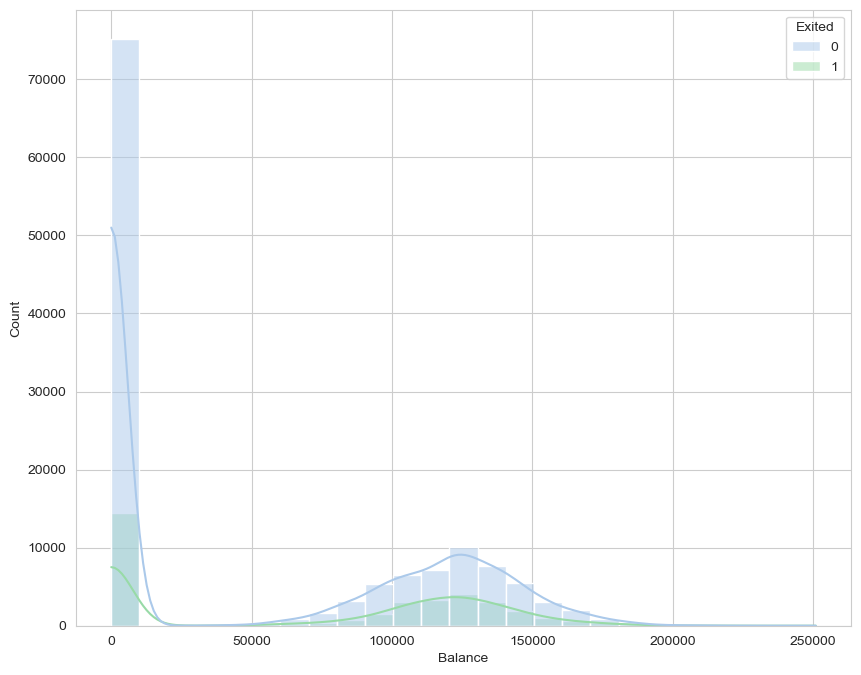

c:\ZERO\ML_Team_Project\eda_source\visualization.py:87: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.histplot(x=x, hue=hue, data=df, kde=True, bins=bins, palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])


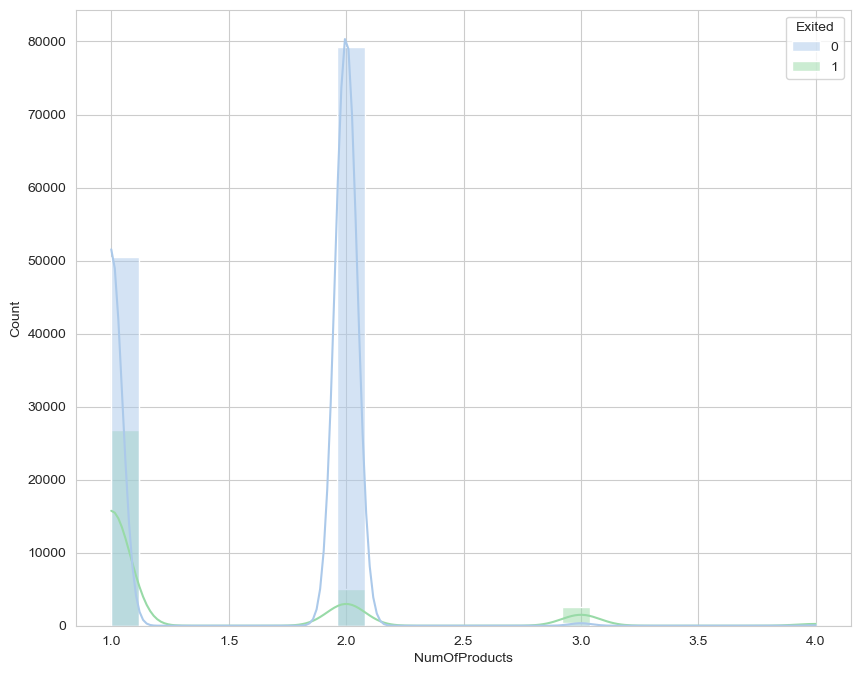

c:\ZERO\ML_Team_Project\eda_source\visualization.py:87: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.histplot(x=x, hue=hue, data=df, kde=True, bins=bins, palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])


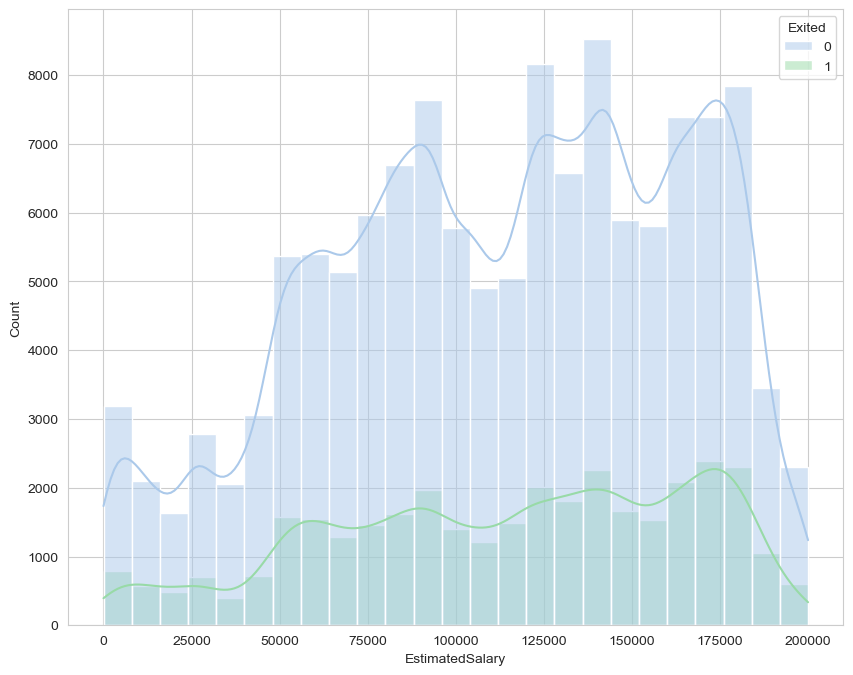

In [25]:
for column in num_cols:
    draw_histplot(df, column, 'Exited')

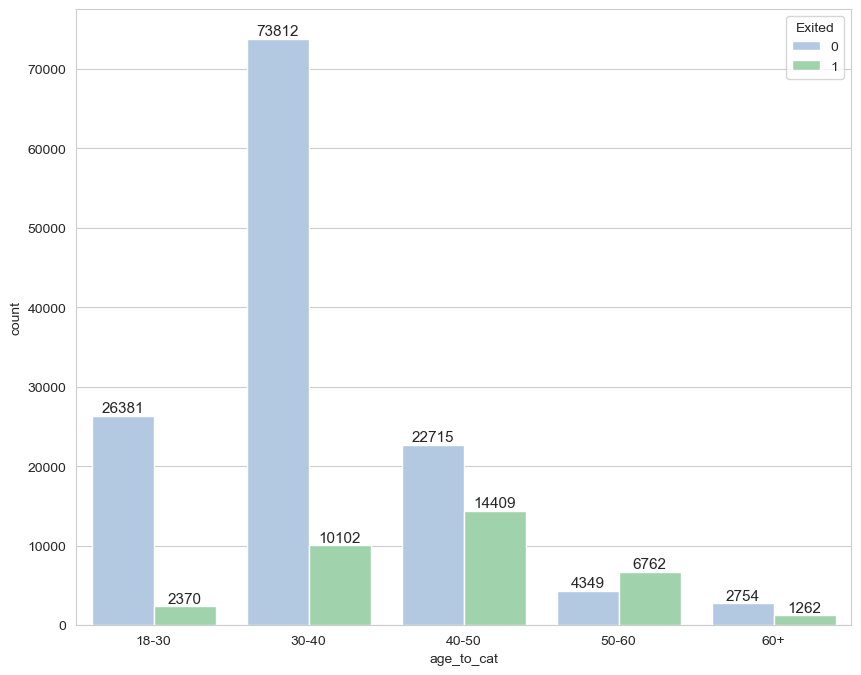

In [29]:
df['age_to_cat'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'])
draw_countplot(df, 'age_to_cat', 'Exited') 

In [32]:
print('잔고 50000 미만 고객 중 이탈 고객 비율 : ', round(len(df.query('(Balance < 50000) & (Exited == 1)')) / len(df.query('(Balance < 50000)')), 4))
print('잔고 50000 이상 고객 중 이탈 고객 비율 : ', round(len(df.query('(Balance >= 50000) & (Exited == 1)')) / len(df.query('(Balance >= 50000)')), 4))
print('전체 이탈 고객 중 잔고 50000 미만 고객 비율 : ', round(len(df.query('(Balance < 50000) & (Exited == 1)')) / len(df.query('Exited == 1')), 4))

잔고 50000 미만 고객 중 이탈 고객 비율 :  0.162
잔고 50000 이상 고객 중 이탈 고객 비율 :  0.2709
전체 이탈 고객 중 잔고 50000 미만 고객 비율 :  0.4167


### 수치형 컬럼 관찰 결과:
- 나이
    - 전체 고객에서 30대가 가장 높은 비중을 차지합니다.
    - 50세를 전후한 나이에서 이탈 고객이 비이탈 고객보다 더 높은 숫자를 보입니다.
    - 이탈 고객은 40대가 가장 많은데, 연령대별 고객 중 이탈 고객의 비율은 50대가 가장 높습니다.
    - 18~40세까지의 고객에 비해 그 보다 연령대가 높은 고객들의 이탈 비율이 높습니다.
- 신용점수 분포는 600-700점 사이의 고객이 비교적 많습니다.
- 가입 기간으로는 1년 미만 고객의 분포가 가장 적고, 1년 이상 9년 이하 고객의 분포가 대부분이며, 9년이상 고객의 수가 가장 많습니다. 
- 계좌 잔액
    - 25000 미만인 고객이 가장 많습니다.
    - 잔액이 50000 이상인 고객의 이탈률이 더 높습니다. 하지만, 이탈 고객 중 41%가 잔액이 50000 미만입니다.
- 고객 보유 상품 수로는 2개를 가진 고객이 가장 많고, 다음으로는 1개를 가진 고객이 많습니다.
- 예상 급여로는 125000이상 175000미만 고객이 가장 많고, 50000이하인 고객이 비교적 적습니다.

- 이용 상품
    - 이용 상품이 많으면 은행의 충성 고객이라고 생각하기 쉬운데, 가입상품이 3, 4개인 고객들의 이탈비율이 더 높게 나타납니다. 다수의 은행 상품을 이용하는 고객들은 재테크에 관심이 높다고 할 수 있는데, 이런 고객들이 상품 조건 등에 더 민감하게 반응해서 이탈했을 가능성이 있습니다. 통신사 사례에서도 비슷한 부분이 있었는지 확인이 필요합니다.
    - 영업전략으로는 이용 상품이 1개인 고객들을 2개로 만드는게 중요해 보입니다.(인과관계?)

> 분석 결과 : 
- 연령대가 높고, 계좌 잔액이 큰 고객의 니지를 충족시킬만한 상품이 부족하지 않을까 추측

### 박스 플랏

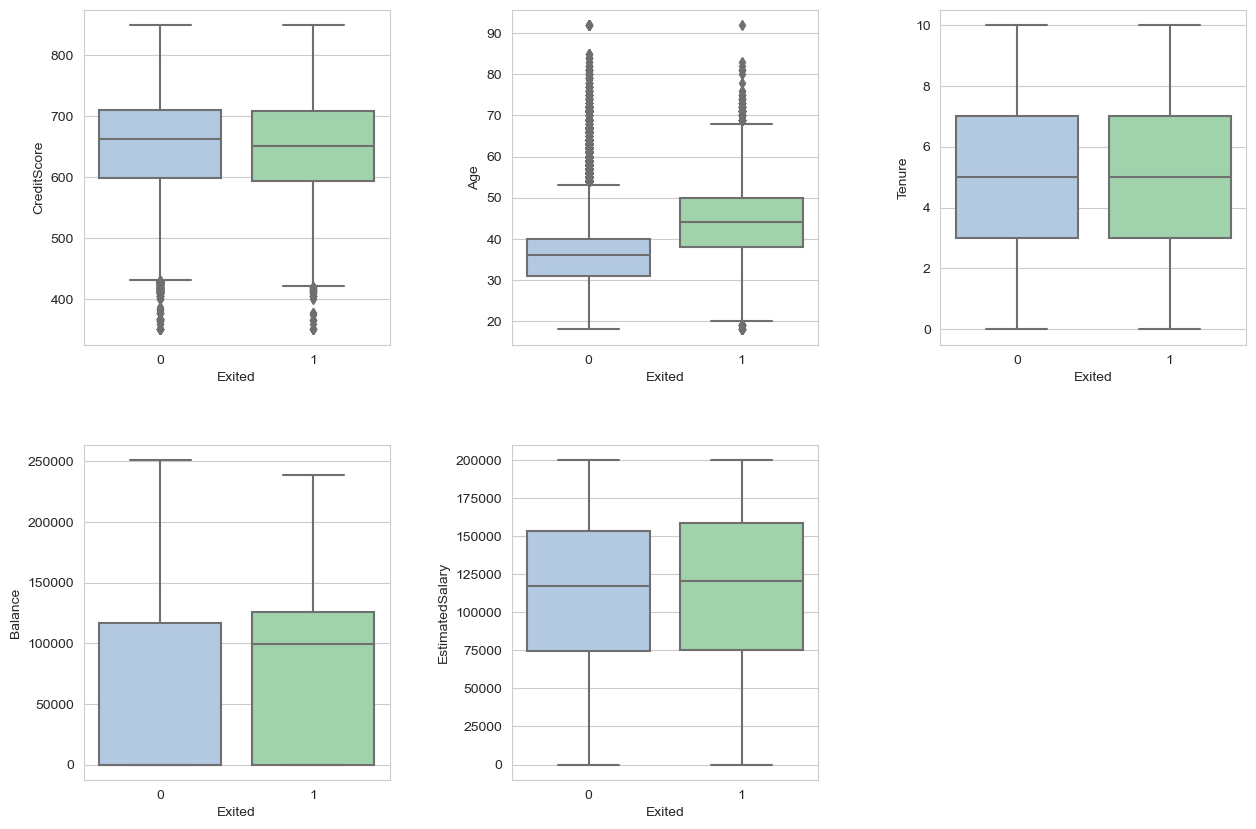

In [33]:
nrows = 2
ncols = 3
fig, ax, = plt.subplots(nrows, ncols, figsize = (15, 10))
sns.boxplot(data=df, x='Exited', y='CreditScore', ax=ax[0, 0], palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])
sns.boxplot(data=df, x='Exited', y='Age', ax=ax[0, 1], palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])
sns.boxplot(data=df, x='Exited', y='Tenure', ax=ax[0, 2], palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])
sns.boxplot(data=df, x='Exited', y='Balance', ax=ax[1, 0], palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])
sns.boxplot(data=df, x='Exited', y='EstimatedSalary', ax=ax[1, 1], palette=["#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af","#c0ebe9"])
ax[1, 2].set_visible(False)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

### 상관 계수 확인

In [40]:
df_digit = df.select_dtypes(include=['int64', 'float64']).drop(['id', 'CustomerId'], axis=1)
df_digit.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0


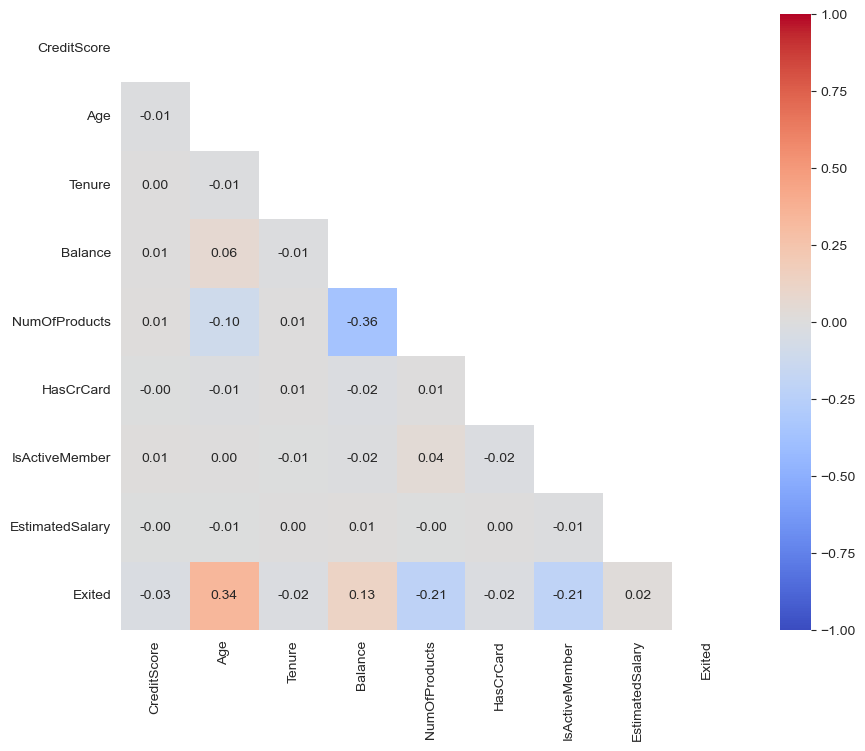

In [41]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df_digit.corr(), dtype=bool))
sns.heatmap(df_digit.corr(), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [38]:
df_cat = df.select_dtypes(exclude=['int64', 'float64']).drop(['Surname', 'Exited_label', 'age_to_cat'], axis=1)
df_cat.head()

,Geography,Gender
0,France,Male
1,France,Male
2,France,Male
3,France,Male
4,Spain,Male


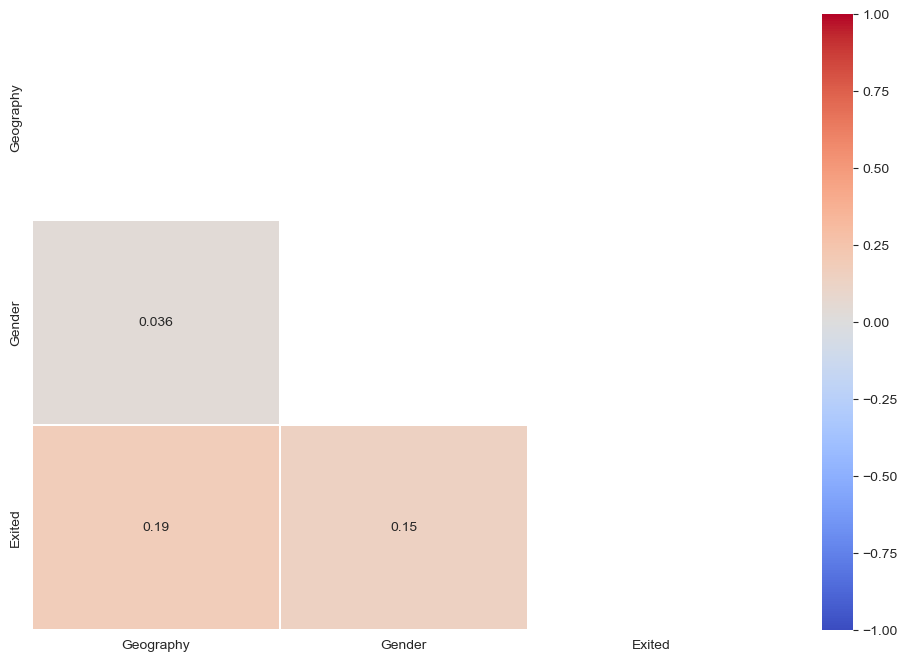

In [39]:
df_cat_corr = pd.concat([df_cat, df['Exited']], axis=1).apply(lambda x: pd.factorize(x)[0]).corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_cat_corr, dtype=bool))
ax = sns.heatmap(df_cat_corr, mask=mask, xticklabels=df_cat_corr.columns, yticklabels=df_cat_corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

- 나이, 가입상품수, 활성멤버여부, 잔고, 거주국가, 성별 등이 이탈률과 상관관계가 있어 보입니다.
- 범주형 데이터의 경우 상관계수를 통한 분석이 적절치 않으므로 참고로만 사용

### 'Surname' 컬럼 분석

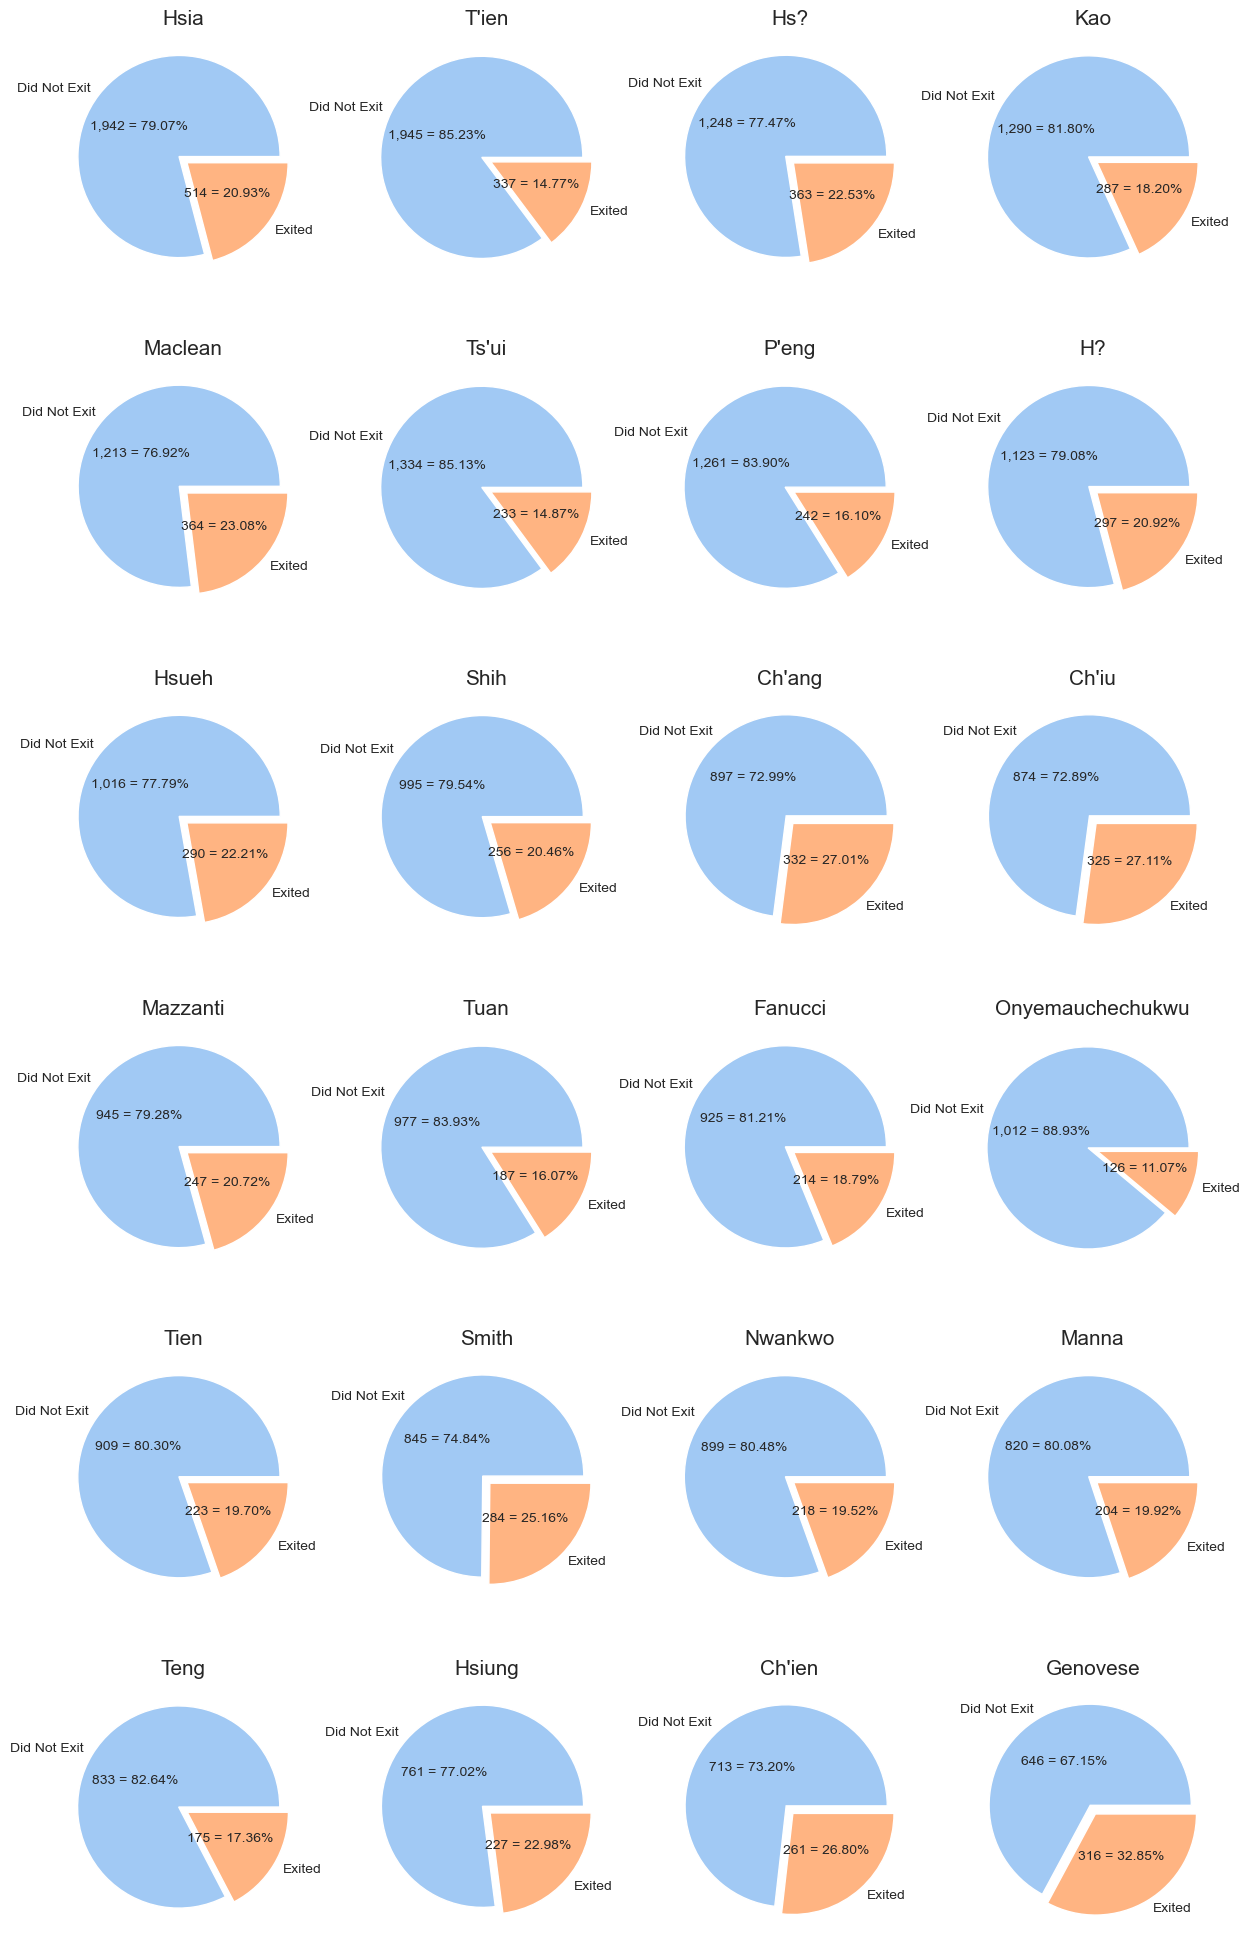

In [51]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(15, 25))
sns.set_palette('pastel')

top_surnames = [surname for surname in df["Surname"].value_counts().nlargest(24).index]
labels = top_surnames.copy()
axs = axs.flatten()

for ag, surname in enumerate(top_surnames):
    data = [
        df[(df["Exited"] == 0) & (df["Surname"] == surname)]["id"].count(),
        df[(df["Exited"] == 1) & (df["Surname"] == surname)]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]
    _ = axs[ag].pie(
        data, labels=label,
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2,
        pctdistance=0.5,
        colors=sns.color_palette("pastel")[0:2],
    )
    _ = axs[ag].set_title(f"{labels[ag]}", fontsize=15)

axs[5].set_axis_off()

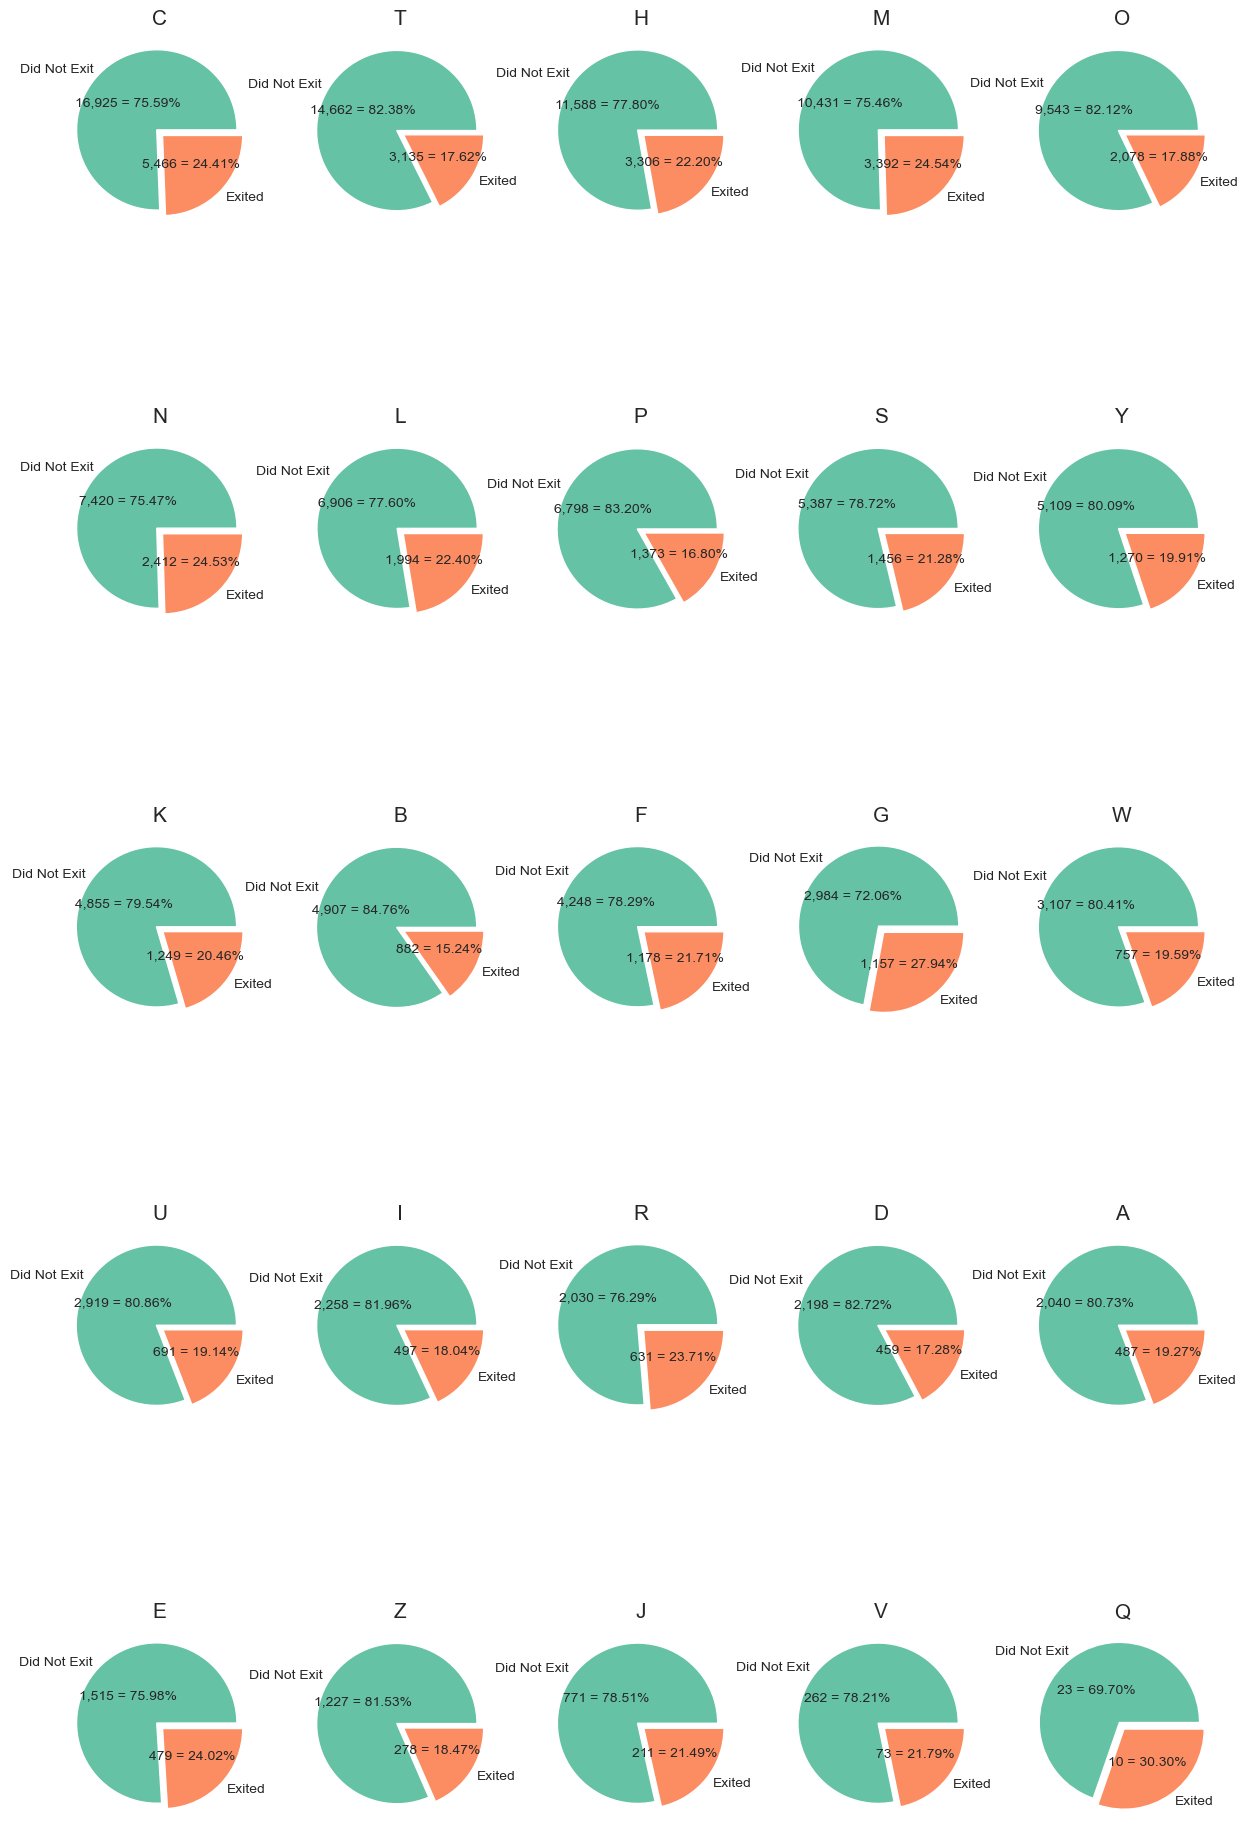

In [53]:
# 성씨의 종류가 다양하니 이를 첫글자로만 나타내고 다시 확인해보자

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 25))

df['First Letter of Surname'] = df['Surname'].apply(lambda x : x[0])
sns.set_palette('Set2')

top_firstletters = [firstletter for firstletter in df["Surname"].apply(lambda x : x[0]).value_counts().index]
labels = top_firstletters.copy()
axs = axs.flatten()

for ag, firstletter in enumerate(top_firstletters):

    data = [
        df[(df["Exited"] == 0) & (df['First Letter of Surname'] == firstletter)]["id"].count(),
        df[(df["Exited"] == 1) & (df['First Letter of Surname'] == firstletter)]["id"].count()
    ]

    label = ["Did Not Exit", "Exited"]

    _ = axs[ag].pie(
        data, labels=label,
        autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
        explode=[0.05] * 2,
        pctdistance=0.5,
        colors=sns.color_palette("Set2")[0:2],
    )
    _ = axs[ag].set_title(f"{labels[ag]}", fontsize=15)

axs[5].set_axis_off()

- 성에 따라 이탈률 차이를 보입니다. 성에 따른 차이가 비즈니스 측면에서 어떤 의미를 갖는지 확인이 필요합니다.

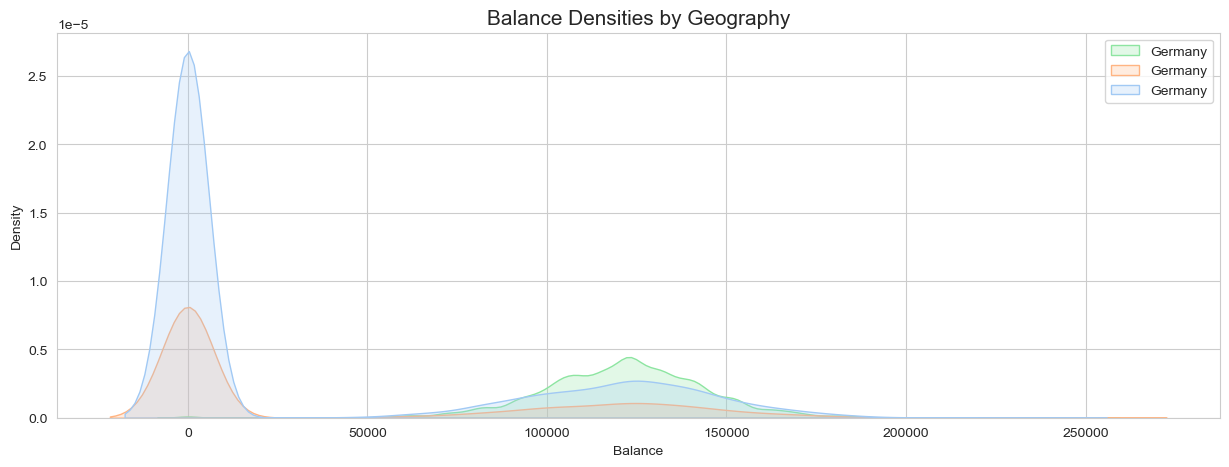

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.kdeplot(data=df, x='Balance', hue='Geography', fill=True, ax=axs, label="Germany", color='r', palette='pastel')
axs.set_title("Balance Densities by Geography", fontsize=15)
axs.set_ylabel("Density")
axs.set_xlabel("Balance")
axs.legend()
plt.show()

# 확장 가능한 주제들
- 연령대에 따른 고객 이탈
- 은행 잔고에 따른 고객 이탈 - 잔고가 50000 미만 고객보다 50000 이상 고객의 이탈률이 더 높았음
- 가입 상품수와 고객 이탈수 - 3, 4개 가입자의 이탈 수가 높았던 이유

# 고객 이탈과 관계성 있는 feature(데이터 추가 탐색)
- 예적금 금리 변동 자료: 예적금 금리 올려 고객 이탈율 최소화(https://www.thepublic.kr/news/articleView.html?idxno=82082)
- 은행 마케팅 진행비: 은행 마케팅 진행 비용과 고객 이탈율 관계